# Speech recognition

Simple sppeech recognition system can be implemented using DTW + MFCC. 

We will use a simple [database](https://www.dropbox.com/s/c12fmsctfwwov5d/sounds.zip) composed of 12 french words pronounced about 25 times by different speakers.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('sounds/wavToTag.txt') as f:
    labels = array([l.replace('\n', '') for l in f.readlines()])
    
print set(labels)

set(['chaussure', 'manette', 'stade', 'jeuvideo', 'beckham', 'zidane', 'ballon', 'gants', 'sofoot', 'girondins', 'cocacola', 'biere'])


## Precompute all MFCCs

In [3]:
import librosa

mfccs = {}

for i in range(len(labels)):
    y, sr = librosa.load('sounds/{}.wav'.format(i))
    mfcc = librosa.feature.mfcc(y, sr, n_mfcc=13)
    mfccs[i] = mfcc.T

## Leave P Out Cross Validation

In [4]:
def generate_train_test_set(P):
    train = []
    test = []

    for s in set(labels):
        all = find(labels == s)
        shuffle(all)
        train += all[:-P].tolist()
        test += all[-P:].tolist()
        
    return train, test

In [5]:
from dtw import dtw

# We use DP to speed up multiple tests
D = ones((len(labels), len(labels))) * -1

def cross_validation(train, test):
    score = 0.0

    for i in test:
        x = mfccs[i]

        dmin, jmin = inf, -1
        for j in train:
            y = mfccs[j]
            
            d = D[i, j]
            if d == -1:
                d, _, _, _ = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
                D[i, j] = d                

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (labels[i] == labels[jmin]) else 0.0
        
    return score / len(test)

In [6]:
train, test = generate_train_test_set(P=1)
rec_rate = cross_validation(train, test)
print 'Recognition rate {}%'.format(100. * rec_rate)

Recognition rate 83.3333333333%


The next plot may take a while to compute!

(0, 1)

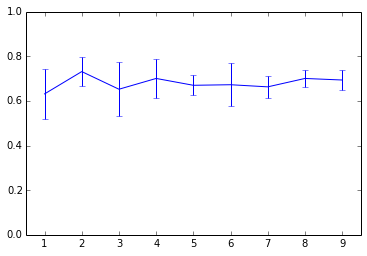

In [12]:
P = arange(1, 10)
N = 5

rec = []

for p in P:
    r = [cross_validation(*generate_train_test_set(p)) for _ in range(N)]
    rec.append(r)
    
rec = array(rec)
rec = rec.reshape((N, -1))

errorbar(P - 0.5, mean(rec, axis=0), yerr=std(rec, axis=0))
xticks(P - 0.5, P)
ylim(0, 1)